In [2]:
#import relevant libraries
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone import ViewField as F
import fiftyone.brain as fob
import cv2
import random
import pandas as pd
import numpy as np
import json
import csv
from datetime import datetime, timedelta

import os
from xml.etree.ElementTree import parse, Element, SubElement, ElementTree
import xml.etree.ElementTree as ET
from collections import defaultdict
import nltk
from nltk.corpus import wordnet
import shutil

import matplotlib.pyplot as plt
from matplotlib import style
%matplotlib inline
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from pathlib import Path
from PIL import Image, ImageOps
import tensorflow
import glob
sns.set_style('white')
sns.set_palette(sns.color_palette('Paired'))
pip install imutils

## Viewing Downloaded Sample Data Using Fiftyone

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz


# Load 300 random samples from the train split
# Only the required images will be downloaded (if necessary).
# By default, all label types are loaded


dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types=["detections"],
    classes=['Luggage and bag', 'Backpack', 'Handbag', 'Person'],
    max_samples=300,
    shuffle=True,
)

session = fo.launch_app(dataset)

Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.
Ignoring invalid classes ['Luggage and bag']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`
Necessary images already downloaded
Existing download of split 'train' is sufficient
Loading 'open-images-v6' split 'train'
Ignoring invalid classes ['Luggage and bag']
You can view the available classes via `fiftyone.utils.openimages.get_classes()`
 100% |█████████████████| 300/300 [1.6s elapsed, 0s remaining, 185.2 samples/s]         
Dataset 'open-images-v6-train-300' created


## Random Sample 200 images and csv file entries

In [3]:

CLASS_CSV_PATH=r'C:\Users\mpe_03\Desktop\Fifty1\copy_class_description.csv'
ANNOT_CSV_PATH=r'C:\Users\mpe_03\Desktop\Fifty1\copy_validation_annotations_bbox.csv'
IMG_PATH=r'C:\Users\mpe_03\Desktop\Fifty1\sample_testing'

#Select random IMAGE filenames and their corresponding csv file samples

samples=[]
DEST=r'C:\Users\mpe_03\Desktop\Fifty1\sample_oid200_img'

rand_filenames=random.sample(os.listdir(IMG_PATH), 200) # sampling 200 images
for f in rand_filenames:
    source_path=os.path.join(IMG_PATH, f)
    shutil.copy(source_path, DEST)
    samples.append(f.split('.')[0])
filename=f.split('.')[0]+'.jpg'

raw_df=pd.read_csv('copy_validation_annotations_bbox.csv')
sample_ids=raw_df['ImageID'].tolist() #getting the image sample IDs

filtered_df=raw_df.loc[raw_df['ImageID'].isin(samples)] #filtering the csv for 200 image samples
filtered_df.to_csv('filtered_df.csv', index=False)


## Process the 200 Random Samples (create csv dataframe)

In [4]:
### SAMPLE PATHS
SAMPLE_ANNOT_CSV_PATH=r'C:\Users\mpe_03\Desktop\Fifty1/filtered_df.csv'
IMG_PATH=r'C:\Users\mpe_03\Desktop\Fifty1\sample_testing'

def get_df(SAMPLE_ANNOT_CSV_PATH):

    encrypted_strings=[]
    image_names=[]
    height=[]
    width=[]
    classes=[]
    
    ### Select all classes

    classes_df=pd.read_csv(CLASS_CSV_PATH, usecols=[0,1], header=None) #0 - codename in encrypted str
    oid_classes=list(classes_df[1])
    oid_classes=[item.lower() for item in oid_classes]
    d=dict(classes_df.values)

    labels=['Person','Handbag','Luggage and bags','Backpack']# input the labels

    for v in labels:
        sub_class=classes_df.loc[classes_df[1]==v]
        e=sub_class.iloc[0][0]  
        encrypted_strings.append(e) # getting the list of encrypted codenames in a list
     

    annot_df=pd.read_csv(SAMPLE_ANNOT_CSV_PATH, usecols=['ImageID', 'LabelName', 'XMin', 'YMin', 'XMax', 'YMax', 'IsOccluded','IsTruncated'], index_col=False) #check column names         
    sub_annot=annot_df.loc[annot_df['LabelName'].isin(encrypted_strings)]


    for jpg_file in os.listdir(IMG_PATH):
        if not jpg_file.endswith('jpg'):
            continue
        image_name=os.path.join(IMG_PATH,jpg_file)
        jpg_file=jpg_file.split('.')[0]
        image_names.append(jpg_file)
        image=cv2.imread(image_name)
        h,w=image.shape[:2]
        height.append(h)
        width.append(w)

    dims=pd.DataFrame({'ImageID':image_names,
                       'height':height,
                       'width':width})


    df=pd.merge(sub_annot, dims, on='ImageID', how='outer')
    df.dropna(subset=['height','width'], inplace=True)
    df.dropna(subset=['XMin','YMax','XMax','YMin'], inplace=True)

    df['XMin']=(df['XMin']*df['width']).astype('int64')
    df['YMax']=(df['YMax']*df['height']).astype('int64')
    df['XMax']=(df['XMax']*df['width']).astype('int64')
    df['YMin']=(df['YMin']*df['height']).astype('int64')
    df['height']=df['height'].astype('int64')
    df['width']=df['width'].astype('int64')
    
    df['IsOccluded']=df['IsOccluded'].astype('int64')
    df['IsTruncated']=df['IsTruncated'].astype('int64')
    
    df.replace({'LabelName':d}, inplace=True)
    df.columns=df.columns.str.lower()
    df=df[['imageid', 'width','height','labelname', 'xmin', 'ymin', 'xmax', 'ymax', 'isoccluded','istruncated']]
    
    df.to_csv('processed_df.csv', index=0)
    return df #check
   
df=get_df(SAMPLE_ANNOT_CSV_PATH)


## Create XML for 200 Random Samples

In [5]:

save_root2 = "sample_oid200_xmls"

if not os.path.exists(save_root2):
    os.mkdir(save_root2)


def write_xml(folder, filename, bbox_list): #create xml components and assign values
    root = Element('annotation')
    SubElement(root, 'folder').text = folder
    SubElement(root, 'filename').text = filename.split('.')[0]
    SubElement(root, 'path').text = './images/' +  filename.split('.')[0]
    source = SubElement(root, 'source')
    SubElement(source, 'database').text = 'Unknown'


    # Details from first entry
    e_filename, e_width, e_height, e_LabelName, e_xmin, e_ymin, e_xmax, e_ymax, IsOccluded, IsTruncated = bbox_list[0]
    
    size = SubElement(root, 'size')
    SubElement(size, 'width').text = e_width
    SubElement(size, 'height').text = e_height
    SubElement(size, 'depth').text = '3'

    SubElement(root, 'segmented').text = '0'

    for entry in bbox_list: # Getting values from subsequent entries
        e_filename, e_width, e_height, e_LabelName, e_xmin, e_ymin, e_xmax, e_ymax,  IsOccluded, IsTruncated= entry
        
        obj = SubElement(root, 'object')
        SubElement(obj, 'name').text = e_LabelName
        SubElement(obj, 'pose').text = 'Unspecified'
        SubElement(obj, 'truncated').text = IsTruncated
        SubElement(obj, 'difficult').text = '0'
        SubElement(obj, 'occluded').text = IsOccluded

        bbox = SubElement(obj, 'bndbox')
        SubElement(bbox, 'xmin').text = e_xmin
        SubElement(bbox, 'ymin').text = e_ymin
        SubElement(bbox, 'xmax').text = e_xmax
        SubElement(bbox, 'ymax').text = e_ymax

    #indent(root)
    tree = ET.ElementTree(root)
    ET.indent(tree, space='\t', level=0)
    
    xml_filename = os.path.join('.', folder, os.path.splitext(filename)[0] + '.xml')
    tree.write(xml_filename)
    
    
entries_by_filename = defaultdict(list) #entries_by_filename holds a dict with values that are list

with open('processed_df.csv', 'r', encoding='utf-8') as f_input_csv:
    csv_input = csv.reader(f_input_csv)
    header = next(csv_input)

    for row in csv_input: #traverse through the rows
        filename, width, height, labelName, xmin, ymin, xmax, ymax,  isoccluded, istruncated = row
        entries_by_filename[filename].append(row) #for whole csv to xml
        
for filename, entries in entries_by_filename.items():
    print(filename, len(entries))
    write_xml(save_root2, filename, entries) #for the 200 samples

001a809ad40a2f84 2
0040009ad56c2bc2 1
00a159a661a2f5aa 1
049b2fae5ca8aa8b 1
0925ac3567b20f47 6
0998d865cd16ccec 1
09a0196247b827e2 1
09e094375efab7fe 5
0a13dcaaab9a35e0 1
0c0b04fe609249d6 1
0c3f952508fc96ec 3
0f71470b9d22554e 1
0f9de77259983016 1
0fd42fdd6970fbf3 3
104a87e61aa3f85a 1
10e939ffae0c2f25 1
12853decdd2ff3bf 1
131bda93f0c34679 2
141a942ad44d3080 3
141d8961e111ead7 1
142d217fff4ec9b6 1
14803b0fc8a74c24 1
14872989780e2c72 1
15b5f14269384832 1
19a1e09742a09af8 1
1cbed7735563a5c6 1
1f21eeca4577a562 3
203e9d889d5fd26d 3
2192e031f570a4d5 1
232299e70b9fe949 1
27177e10a15ea68b 1
2788147877e5ebb6 1
27e3a6fb64a558e7 1
292b9d4db55cd308 1
293e3c74bb0cff7c 1
295a2ffafd5da7fa 2
2a2f1361baf50a7b 7
2aedc2efa2b67e07 1
2b046ed2fcd7b9d1 2
30e6f3ca1da64271 3
30ffde725ba6f072 2
318e12be63daa7bb 3
32463d6e4de294b6 1
3297cd4765b3f3ed 3
335197067b30029e 9
362bdfbc0fdaa76f 1
368f0045b95affc3 1
37860e490399c045 2
38a713b634ea640b 1
390cce601a67389a 1
3a28cdaca4cff49b 1
3b593df0c7287c7c 2
3bcf95f7f6a5

## PRE-DOWNLOADER VISUAL CHECK SUMMARY OF 200 RANDOM SAMPLES

In [ ]:
## Before downloading full dataset check csv for:
1. Imbalanced classes
2. Too small bounding boxes in specific classes (<=3%)
3. Large bounding boxes (possiblly grouped annotations) (>85%)


In [6]:
df=pd.read_csv('processed_df.csv')
print(f'Number of duplicate rows: {df.duplicated().sum()}')

In [7]:
df['box_area']=(df['ymax']-df['ymin'])*(df['xmax']-df['xmin'])
df['image_size']=df['height']*df['width']
df['box_percent_area']=df['box_area']/df['image_size']
df['box_sizes']=pd.cut(x=df['box_percent_area'],
                      bins=[-float('inf'),0.03, 0.10, 0.25, 0.50, 0.75, 0.85, float('inf')],labels=['<=3%','<=10%', '<=25%','<=50%','<=75%',\
                                                                                              '<=85%','>85%'])
              

['09e094375efab7fe', 'ad2e6307c9ad4846', '0925ac3567b20f47', '90f42332062eab57', '2a2f1361baf50a7b', '6f9ac6d119149173']


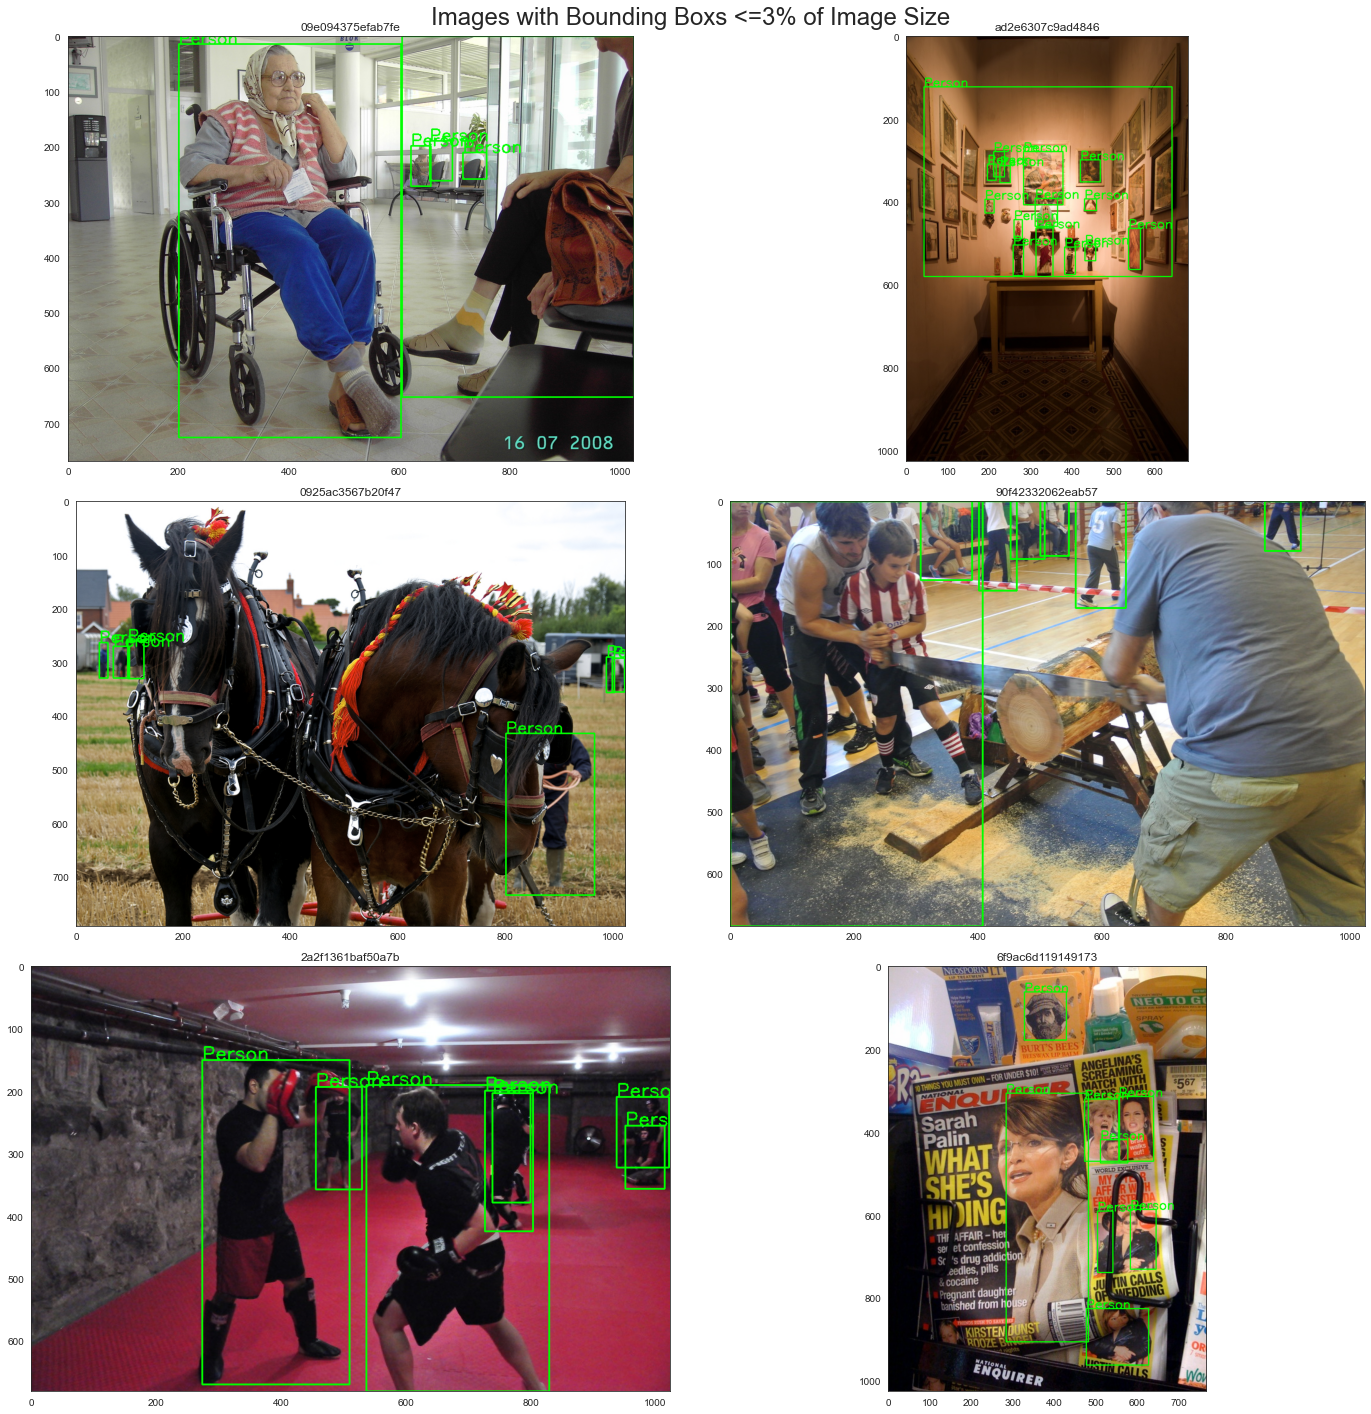

['dd4b82f0b2c0b92a', '30e6f3ca1da64271', 'f2ee7892e8dd6a37', 'daefa976118b3414', '2b046ed2fcd7b9d1']


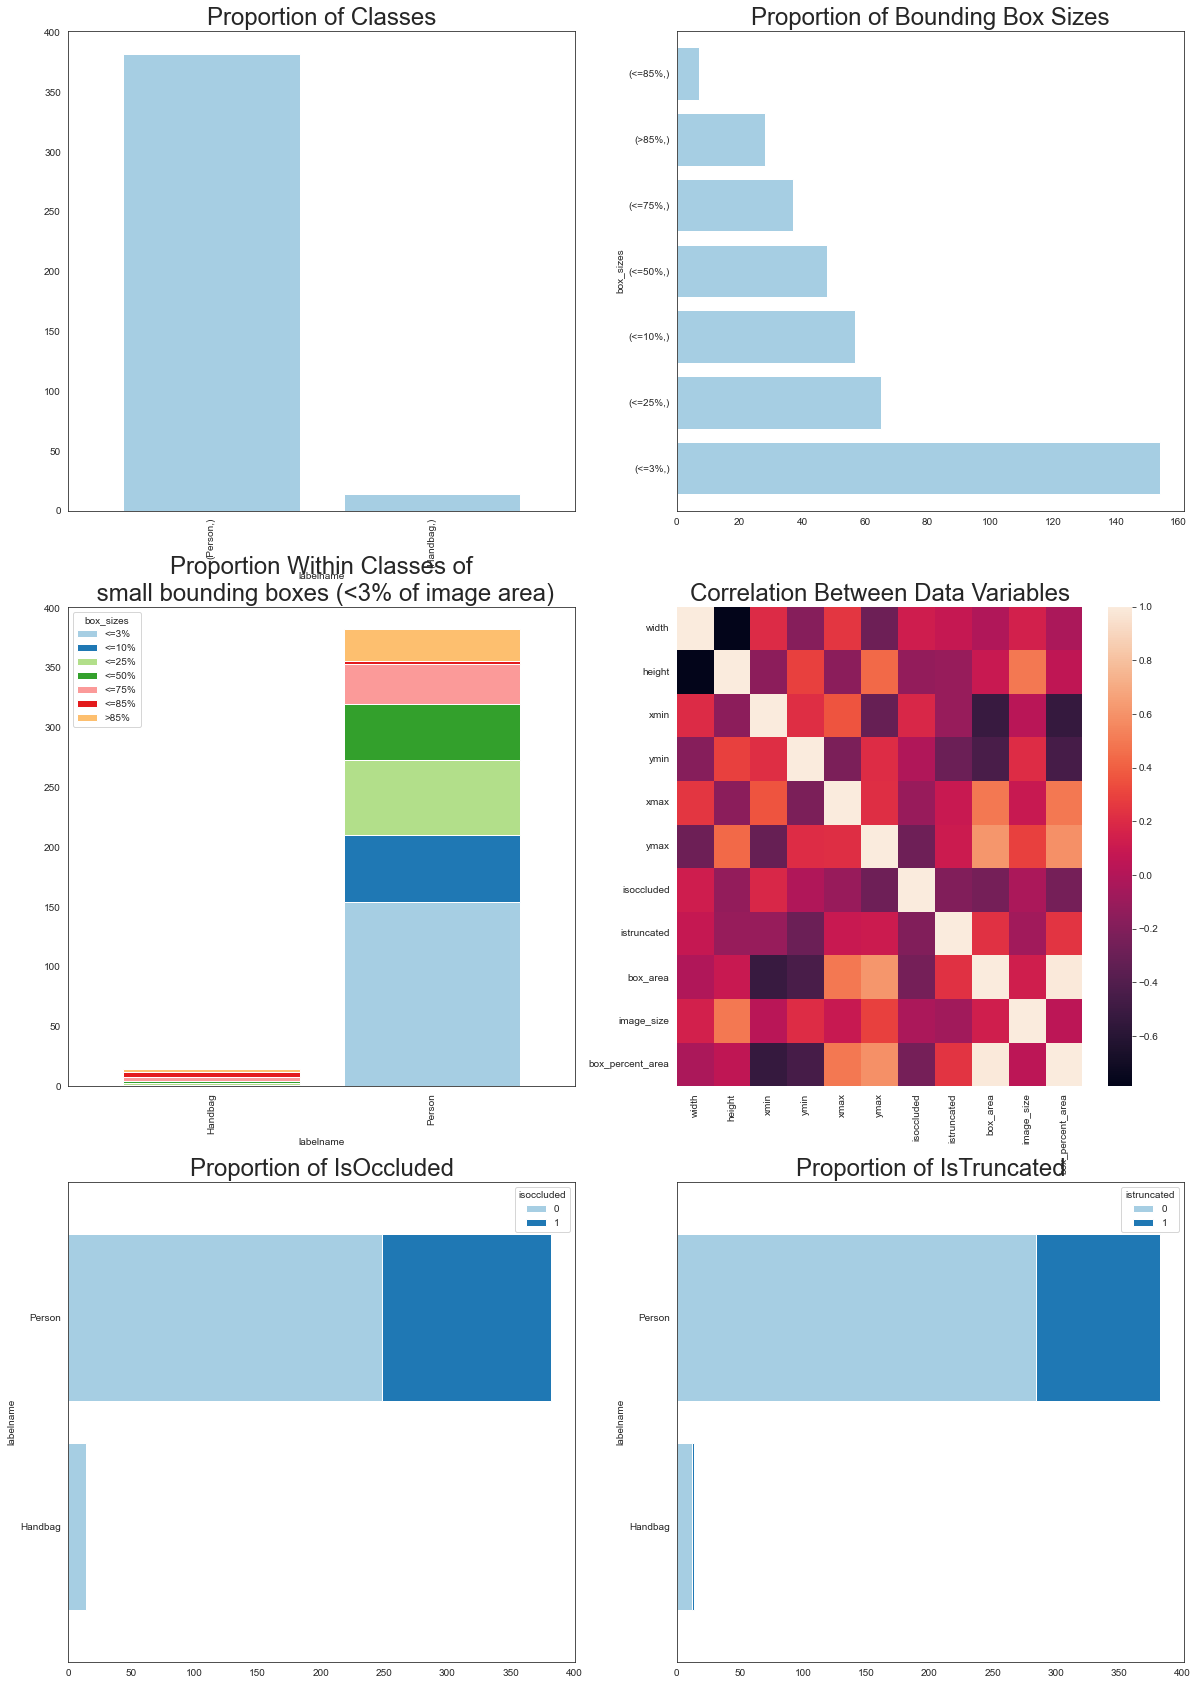

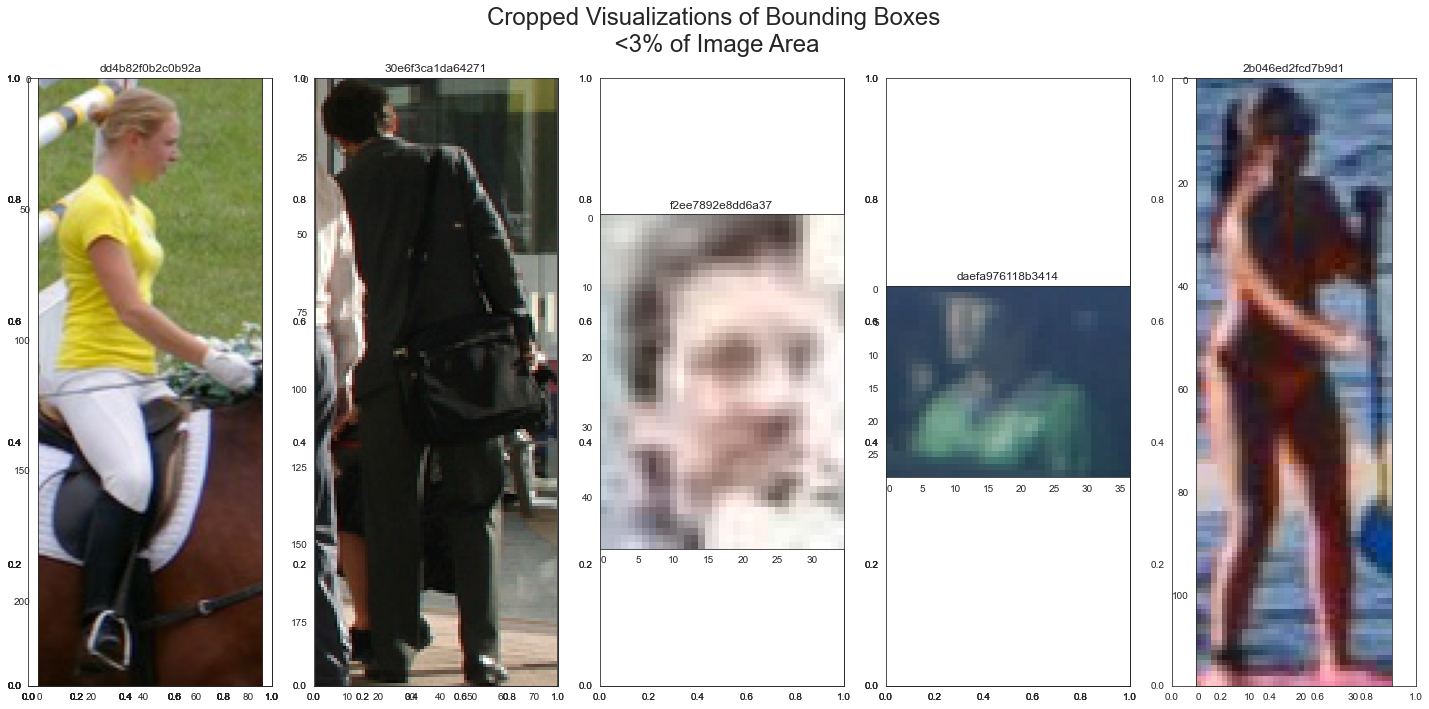

In [9]:
SAMPLE_200_PATH=r'C:\Users\mpe_03\Desktop\Fifty1\sample_oid200_xmls'
IMG_PATH=r'C:\Users\mpe_03\Desktop\Fifty1\sample_oid200_img'
class_list=["Man","Person","Handbag","Backpack"]

def img_xml_plot(IMG_PATH, SAMPLE_200_PATH, class_list, rows=3, columns=2):

    filename = [f.parts[-1].split(".")[0] for f in Path(SAMPLE_200_PATH).iterdir()]
    
    # Display small box images OR
    
    small_box=df.loc[df['box_sizes']=='<=3%']
    small_box_list=small_box['imageid'].to_list()
    rand_filename = random.sample(small_box_list, int(rows * columns))
    print(rand_filename)
    
    #Alternatively
    # Display large box images with only one annotation
    
#     large_box=df.loc[df['box_sizes']=='>85%']
#     large_box_list=large_box['imageid'].to_list()
#     rand_filename = random.sample(large_box_list, int(rows * columns))
#     print(rand_filename)

    
    # 10 different colours for max 10 list

    colour_list = [
        (255, 0, 0),
        (0, 255, 0),
        (0, 0, 255),
        (255, 255, 0),
        (0, 255, 255),
        (255, 0, 255),
        (255, 127, 0),
        (7, 185, 252),
        (204, 204, 255),
        (153, 153, 255),
    ]
    colour_combi = dict(zip(class_list, colour_list[: len(class_list)]))

    fig = plt.figure(figsize=(20, 20))
    for index, file in enumerate(rand_filename):
        # tree = ET.parse(file)
        tree = ET.parse(os.path.join(SAMPLE_200_PATH, f"{file}.xml"))
        root = tree.getroot()
        result = (
            []
        )  # store different bbox and object class within the same file (image)
        for object in root.findall("object"):
            name = object.find("name").text
            for value in object.findall("bndbox"):
                xmin = int(float(value.find("xmin").text))
                ymin = int(float(value.find("ymin").text))
                xmax = int(float(value.find("xmax").text))
                ymax = int(float(value.find("ymax").text))
            result.append([name, xmin, ymin, xmax, ymax])          
        
              
        # read the respective image
        img = cv2.imread(os.path.join(IMG_PATH, f"{file}.jpg")) #array
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        
        
        for i in range(len(result)):
                start = tuple(result[i][1:3])
                end = tuple(result[i][3:])
                img = cv2.rectangle(img, start, end, colour_combi[result[i][0]], 2)
                img = cv2.putText(
                    img,
                    result[i][0],
                    start,
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    colour_combi[result[i][0]],
                2, )
                
#  Visualize the pics
        fig.add_subplot(rows, columns, index + 1)
        plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9,wspace=0.5, hspace=0.5 )
        fig.suptitle('Images with Bounding Boxs <=3% of Image Size',  fontsize=24)
        plt.imshow(img)
        plt.title(f"{file}")
        
    fig.tight_layout()
    plt.show()
        
    
img_xml_plot(IMG_PATH, SAMPLE_200_PATH, class_list, rows=3, columns=2)



#Set figure dimensions
fig, axes=plt.subplots(3,2, figsize=(20,30))

#Detect any imbalanced classes
df[['labelname']].value_counts().plot.bar(width=0.8, ax=axes[0][0])
axes[0,0].set_title('Proportion of Classes', fontsize=24)  #chart on left

#Detect presence of small bounding boxes (<3% of image area)
df[['box_sizes']].value_counts().plot.barh(width=0.8, ax=axes[0][1])
axes[0,1].set_title('Proportion of Bounding Box Sizes', fontsize=24)

#Detect  which class may contain small bounding boxes
tab_label=pd.crosstab(df['labelname'], df['box_sizes'])
tab_label.plot.bar(width= 0.8, stacked= True, ax=axes[1][0])
axes[1,0].set_title('Proportion Within Classes of\n small bounding boxes (<3% of image area)', fontsize=24)

#Observe correlations of raw data
sns.heatmap(df.corr(), ax=axes[1][1]);
axes[1,1].set_title('Correlation Between Data Variables', fontsize=24)

#Observe  which class may contain occulsions
tab_occluded=pd.crosstab(df['labelname'], df['isoccluded'])
tab_occluded.plot.barh(width=0.8, stacked= True, ax=axes[2][0])
axes[2,0].set_title('Proportion of IsOccluded', fontsize=24)

#Observe  which class may contain truncations
tab_truncated=pd.crosstab(df['labelname'], df['istruncated'])
tab_truncated.plot.barh(width=0.8, stacked= True,  ax=axes[2][1])
axes[2,1].set_title('Proportion of IsTruncated', fontsize=24)



def crop_bbox(SAMPLE_200_PATH,IMG_PATH, rows=1,columns=1):
        
    #Randomly select small box images
    filename = [f.parts[-1].split(".")[0] for f in Path(SAMPLE_200_PATH).iterdir()]
    small_box=df.loc[df['box_sizes']=='<=3%']
    small_box_list=small_box['imageid'].to_list()
    rand_filename = random.sample(small_box_list, int(rows * columns))
    print(rand_filename)
    index=0

    fig = plt.figure(figsize=(20, 10))
    for f in rand_filename:
        fullpath=os.path.join(IMG_PATH, f'{f}.jpg')
        img=Image.open(fullpath) #load file
        arr=np.array(img) #convert to array
        index+=1

        #Get  the bbox coordinates
        xml_file_path=os.path.join(SAMPLE_200_PATH, f +'.xml')

        tree=ET.parse(xml_file_path)
        root=tree.getroot()
        for boxes in root.iter('object'):
            
            ymin, xmin, ymax, xmax=None, None, None, None
            ymin=(int(boxes.find("bndbox/ymin").text)) #integer to convert to float
            xmin=(int(boxes.find("bndbox/xmin").text))
            ymax=(int(boxes.find("bndbox/ymax").text))
            xmax=(int(boxes.find("bndbox/xmax").text))
            
        
        # Crop and display small boxes       
            fig.add_subplot(rows, columns, index)
            crop=arr[ymin:ymax, xmin:xmax] #crop
        
        plt.imshow(crop)
        plt.title(f"{f}")
          
        fig.tight_layout()
           
    fig.suptitle('Cropped Visualizations of Bounding Boxes\n <3% of Image Area', fontsize=24)    
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.9,wspace=0.2, hspace=0.2 )
   

    fig.tight_layout()
    plt.show()

crop_bbox(SAMPLE_200_PATH,IMG_PATH,rows=1,columns=5)



# THE END